In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from baselines import load_comments_and_labels, assemble_data, one_hot
from ngram import test_cross,calibration_curve_plotter,two_class_roc_plotter, two_class_precision_recall_plotter
from ngram import roc_scorer, spearman_scorer
import matplotlib.pyplot as plt
import joblib
import os
from serialization import save_pipeline, load_pipeline
import pandas as pd

Using TensorFlow backend.


In [2]:
def eval_n_save_model(task, model_name, debug=False):
    cv_path = '../../models/cv'
    results_path = '../../models/%s/%s' % (task, model_name)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    
    #load data
    data = load_comments_and_labels(task)
    
    
    if 'ed' in model_name:
        label_type = 'empirical_dist'
    elif 'oh' in model_name:
        label_type = 'one_hot'
    X_train, y_train = assemble_data(data, 'comments', label_type, splits = ['train'])
    X_test, y_test = assemble_data(data,  'comments', 'empirical_dist', splits = ['test'])
    
        
    if debug:
        X_train = X_train[:1000]
        y_train = y_train[:1000]
        X_test = X_test[:1000]
        y_test = y_test[:1000]
        
        
    #load architecture
    
    model = load_pipeline(cv_path, model_name)
    
    
    #fit model on train, eval on test
    model.fit(X_train, y_train)
    save_pipeline(model, results_path, model_name + "_train" )
    
    # metrics
    roc_df, spearman_df = test_cross(model, data, 'comments')
    roc_df.to_csv(os.path.join(results_path, 'roc.csv'))
    spearman_df.to_csv(os.path.join(results_path, 'spearman.csv'))
    
    y_test_pred = model.predict_proba(X_test)
    
    calibration_curve_plotter(one_hot(y_test)[:, 1], y_test_pred[:, 1])
    plt.savefig(os.path.join(results_path, 'calibration.png'))
    
    two_class_roc_plotter(y_test, y_test_pred)
    plt.savefig(os.path.join(results_path, 'roc_curve.png'))
    
    two_class_precision_recall_plotter(y_test, y_test_pred)
    plt.savefig(os.path.join(results_path, 'precision_recall_curve.png'))
    
    # train on all data and save model
    X, y = assemble_data(data, 'comments', label_type) 
        
    if debug:
        X=X[:1000]
        y=y[:1000]
        
        
    save_pipeline(model.fit(X, y), results_path, model_name + "_all" )

time: 42.6 ms


In [3]:
tasks = ['attack', 'recipient', 'aggression']
models = ['linear_char_ed', 'mlp_char_ed', 'linear_char_oh', 'mlp_char_oh']

time: 1.07 ms


/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


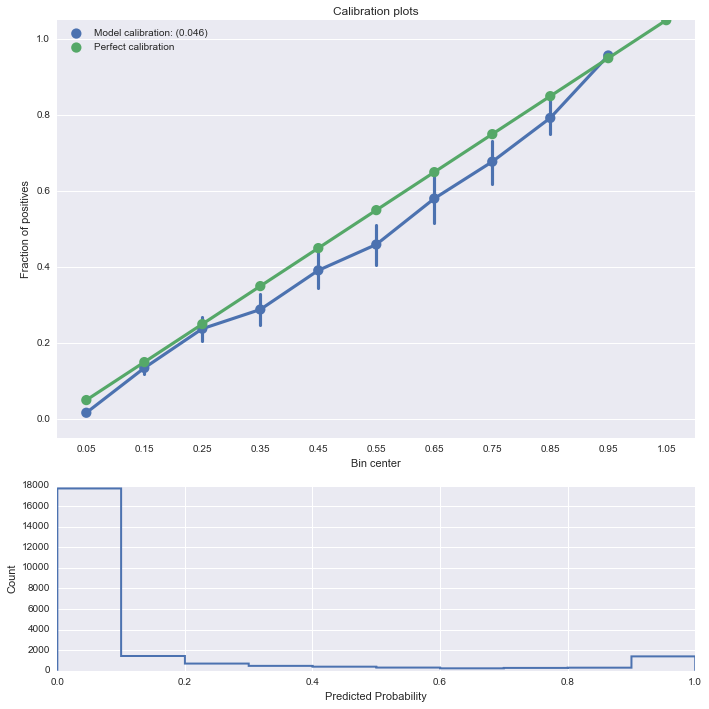

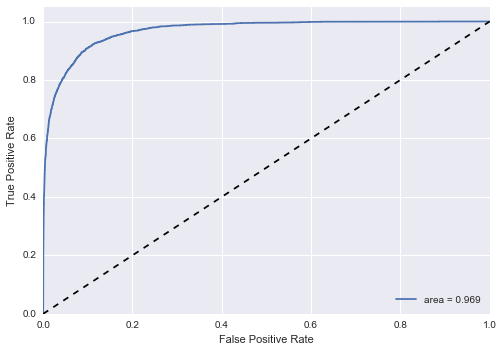

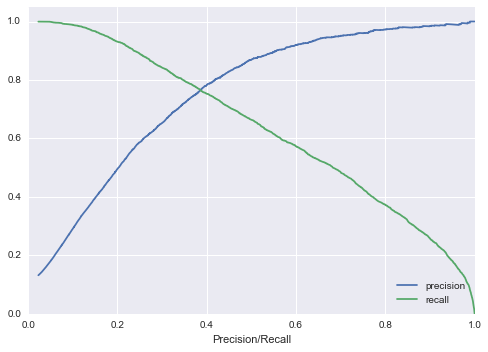

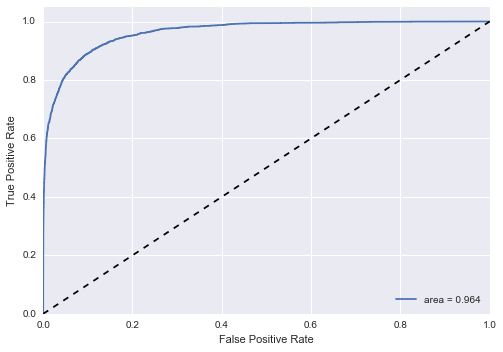

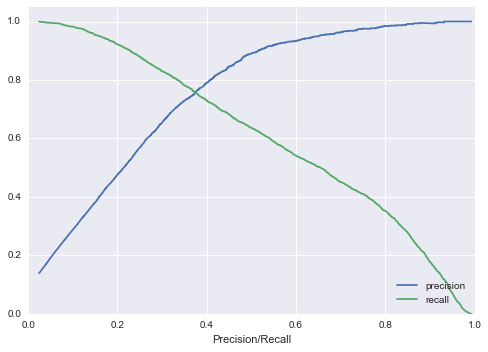

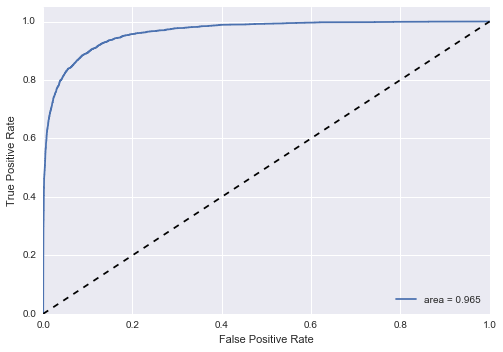

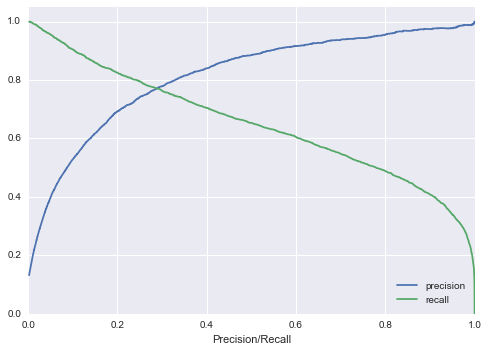

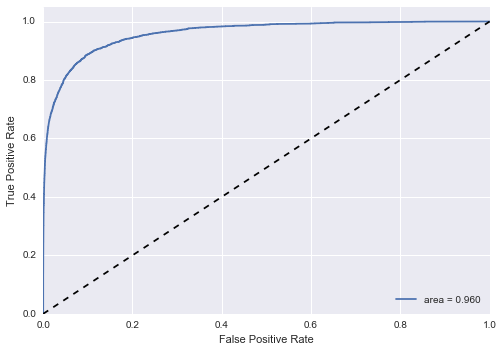

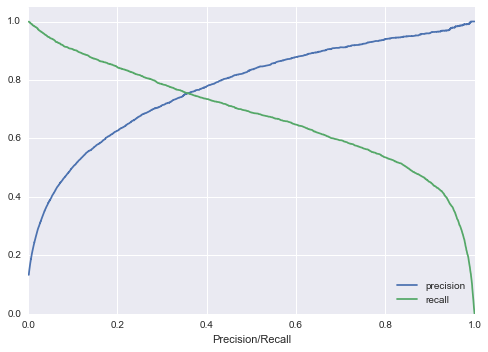

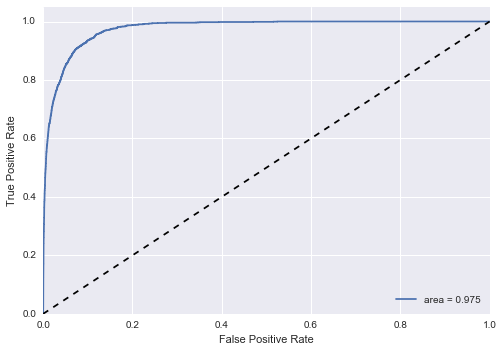

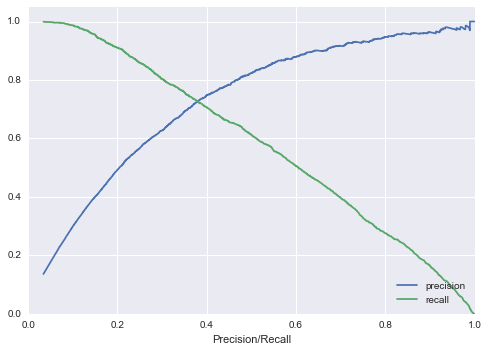

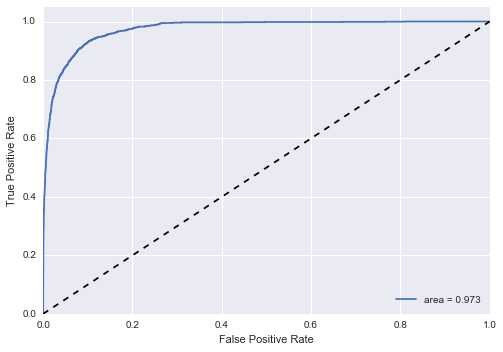

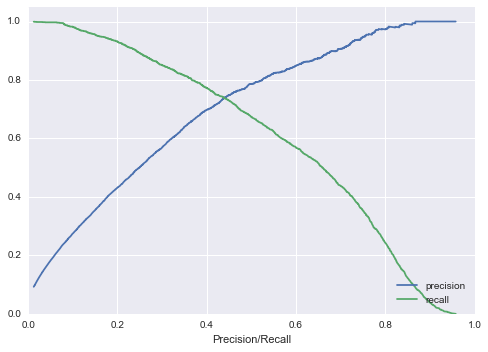

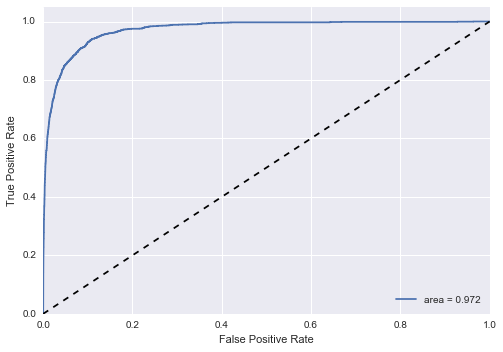

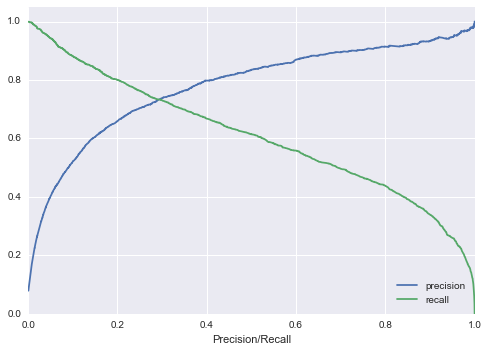

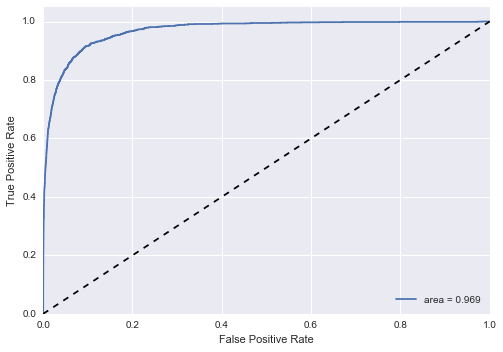

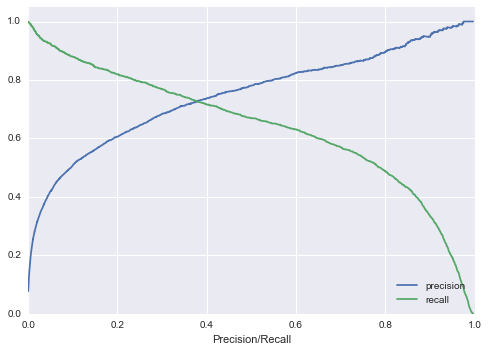

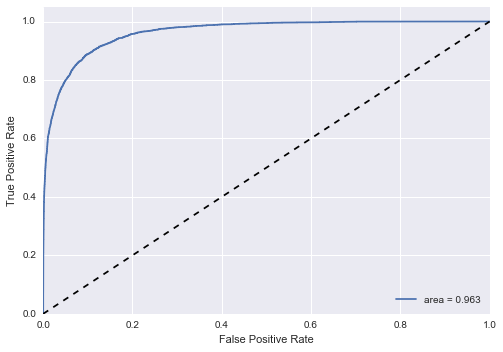

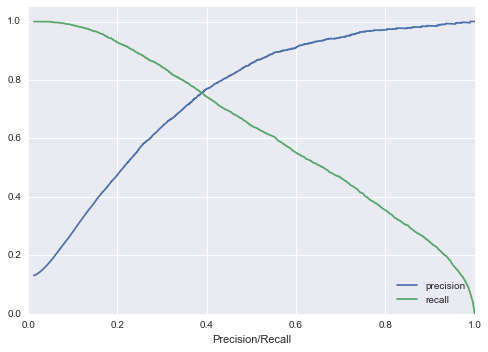

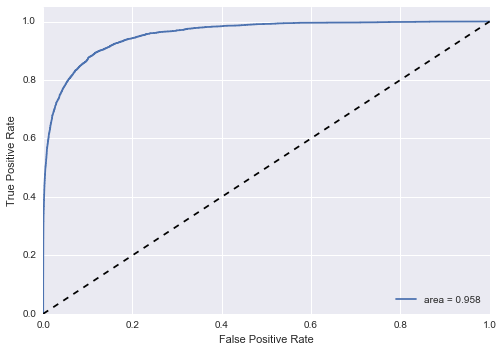

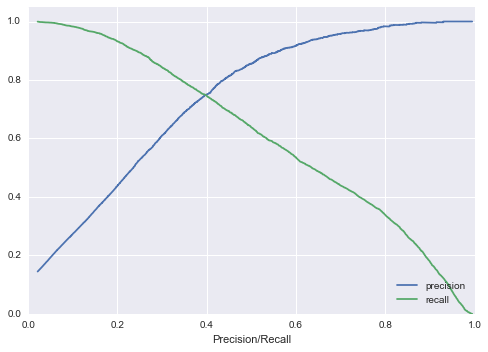

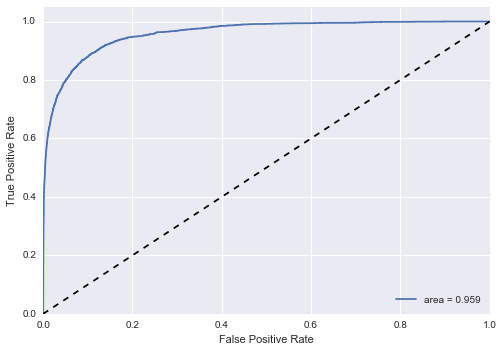

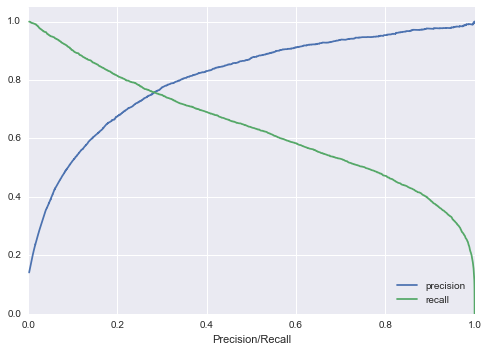

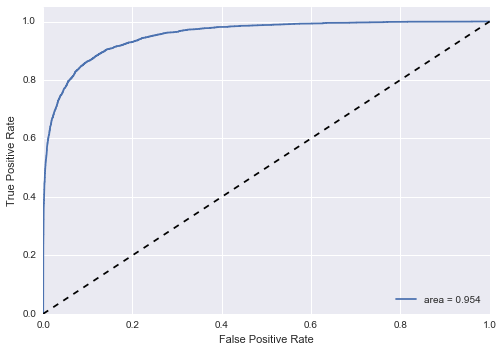

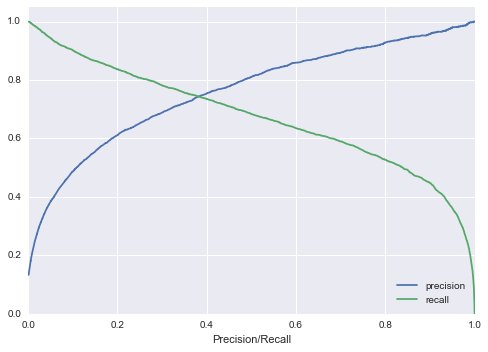

time: 4h 17min 43s


In [4]:
for task in tasks:
    for model in models:
        eval_n_save_model(task, model, debug = False)